In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import re
import time
import timm
import pickle
import numpy as np
import pandas as pd
from fastcore.all import *
from fastai.vision.all import *
from license_plate_detection.model import *
from license_plate_detection.utils import *
from license_plate_detection.loss import FasterRCNNLoss
from fastai.callback.tensorboard import TensorBoardCallback
from license_plate_detection.model.rpn import AnchorGenerator

In [ ]:
import os
os.chdir('/home/aucsie/Documents/practice')

In [ ]:
license_ds_p=Path('/home/aucsie/Documents/practice/license_detector/exps/license_ds.csv')

In [ ]:
root = Path('./CCPD2019')
base_path = root/'ccpd_base'
device='cuda:0'

In [ ]:
df= pd.read_csv(license_ds_p)
df['is_valid']= df['split']=='train'

In [ ]:
def get_ds(root):
    fp = f"{root}/splits/train.txt"
    data= L(Path(l.rstrip()).name for l in open_file(fp, mode='r').readlines())
    return data

In [ ]:
def get_bbox(fp):
    #TODO refactor to dataclass coors
    bbox_str = Path(fp[0]).name.split("-")[2]
    bbox_str = list(map(int, re.findall("\d+", bbox_str)))
    return np.array(bbox_str)

In [ ]:
dblock = DataBlock(blocks= (ImageBlock, BBoxBlock, BBoxLblBlock),
                   splitter= ColSplitter(),
                   get_x=ColReader(0, pref=root),
                   get_y=[get_bbox, lambda o: ['plate']],
                   item_tfms=[Resize(256, method=ResizeMethod.Squish, pad_mode=PadMode.Zeros)],
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                   n_inp=1)

In [ ]:
sub_df=df.groupby('split').apply(lambda x: x.sample(3000,random_state=42))
sub_df=sub_df.reset_index(drop=True)
dls= dblock.dataloaders(sub_df, bs=32)

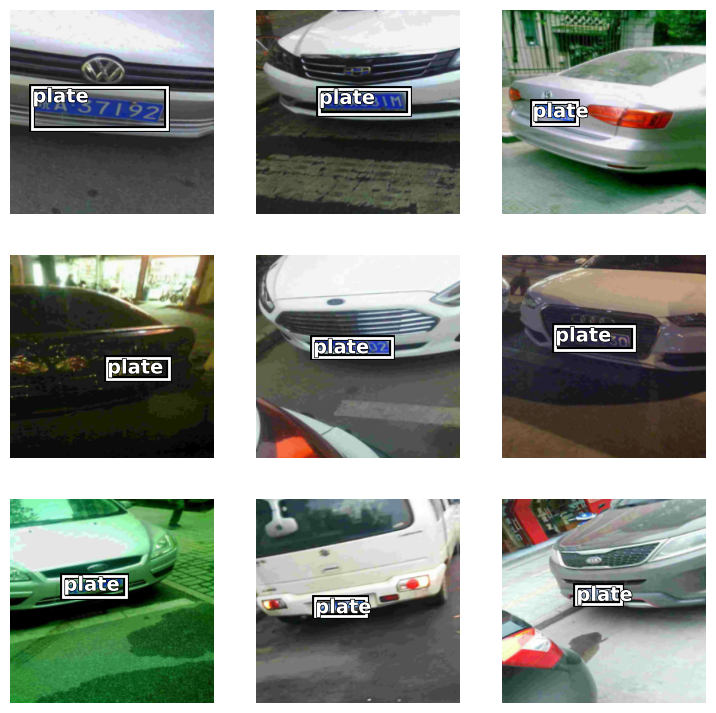

In [ ]:
dls.show_batch()

In [ ]:
class Trainer(Callback):
    def after_pred(self): 
        rois= self.pred[2]
        gts= self.get_gts(rois, self.yb)
        self.learn.yb= (*gts, self.yb)
        
    def get_gts(self, rois, yb):
        size= self.dls.after_item.size[0]
        rpn_gt= self.model.rpn_head.get_rpn_gt(yb[0], size)
        roi_gt= self.model.roi_head.get_roi_gt(rois, *yb, size)
        return rpn_gt, roi_gt

In [ ]:
def get_metrics():
    loss_metrics= ['rpn_loss',
                   'roi_loss', 
                   'rpn_cls_loss', 
                   'roi_cls_loss', 
                   'rpn_reg_loss', 
                   'roi_reg_loss',]

    return L(LossMetric(metric) for metric in loss_metrics)

In [ ]:
#add config opt for rpn and roi
arch='resnet50'
ratios=[0.3,0.5]
scales=[16,32]
nms_pre= 1000
nms_post= 80
nms_thr=0.5
model=FasterRCNN.init_model(arch, dls, ratios, scales, device)

In [ ]:
loss_func= FasterRCNNLoss()
pytorch_adamw = partial(OptimWrapper, opt=torch.optim.AdamW)
opt_func=partial(pytorch_adamw)
learner= Learner(dls, 
                 model, 
                 loss_func=loss_func, 
                 opt_func=pytorch_adamw, 
                 cbs=[Trainer(), ShowGraphCallback])

learner.metrics= get_metrics()

In [ ]:
def pseudo_draw(anchors, im=None, size=128):
    if im is None: t = np.ones([size, size])
    else: t = im
    t = draw_bboxes(t, anchors)
    return t

@patch
def show_results(self:Learner, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
    if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
    b = dl.one_batch()
    img= b[0].permute(0,2,3,1).detach().cpu().contiguous()
    img= np.array(img)
    _,_,preds = self.get_preds(dl=[b], with_decoded=True)
    all_anchors= self.model.rpn_head.all_anchors
    pred_bboxes= decode_roi_preds(preds, all_anchors)
    res_list=[]
    for idx in range(max_n):
        res= pseudo_draw(pred_bboxes[idx,:,:-1], np.copy(img[idx]))
        res_list.append(res)
    show_images([*res_list],nrows=3,ncols=3)

epoch,train_loss,valid_loss,rpn_loss,roi_loss,rpn_cls_loss,roi_cls_loss,rpn_reg_loss,roi_reg_loss,time
0,4.272919,3.355482,0.915270,2.440212,0.642474,0.658100,0.272796,1.782112,03:24


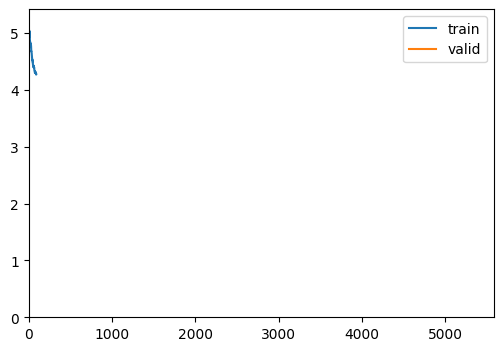

In [ ]:
learner.fit_one_cycle(60, slice(3e-3), wd=1e-3)

In [ ]:
learner.show_results()

In [ ]:
def plot_rpn_bbox(learner):
    dl = learner.dls[0].new(shuffle=True)
    b = learner.dls.train.one_batch()
    img= b[0].permute(0,2,3,1).detach().cpu().contiguous()
    img= np.array(img)
    _,_,preds = learner.get_preds(dl=[b], with_decoded=True)
    rpn_reg_feats, rpn_cls_feats, rois= preds[:3]
    rois= rois[:, 1:].contiguous()
    all_anchors= learner.model.rpn_head.all_anchors
    fg_score=rpn_cls_feats[0,:,1]
    fg_max_score, fg_max_ind= fg_score.sort(descending=True)
    print(fg_max_score[:5])
    fg_max_ind= fg_max_ind[:5]
    bbox=reverse_offset(all_anchors[fg_max_ind], rpn_reg_feats[0, fg_max_ind].to(device))
    g= unscale_pnts(b[1], 256).squeeze(0).detach().cpu().numpy()
    pr= pseudo_draw(bbox[:1], np.copy(img[0]))
    gt= pseudo_draw(g[0], np.copy(img[0]))
    show_images([pr, gt])

In [ ]:
def plot_roi_bbox(learner):
    dl = learner.dls[0].new(shuffle=True)
    b = dl.one_batch()
    img= b[0].permute(0,2,3,1).detach().cpu().contiguous()
    img= np.array(img)
    _,_,preds = learner.get_preds(dl=[b], with_decoded=True)
    rois, roi_reg_feats, roi_cls_feats= preds[2:]
    rois= rois[:,:,1:].contiguous()
    pred_bbox, gt_bbox=[],[]
    for idx,_ in enumerate(rois):
        fg_score= roi_cls_feats[idx,:,1:]
        fg_max_score, fg_max_ind= fg_score.sort(descending=True, dim=0)
        fg_max_ind= fg_max_ind[:5]
        bbox= reverse_offset(rois[idx,fg_max_ind.squeeze(1)], roi_reg_feats[idx,fg_max_ind.squeeze(1)])
        # bbox= torch.clamp(bbox, min=0, max=256)
        bbox= torch.hstack([bbox, fg_max_score[:5]])
        bbox= nms(bbox, 0.5)
        gt= unscale_pnts(b[1][idx], 256).squeeze(0).detach().cpu().numpy()
        pred_bbox.append(bbox)
        gt_bbox.append(gt)
    print(pred_bbox[0][:, -1])
    print(pred_bbox[0][:, :-1])
    pr= pseudo_draw(pred_bbox[0][:,:-1], np.copy(img[0]))
    gt= pseudo_draw(gt_bbox[0][None,:], np.copy(img[0]))
    show_images([pr, gt])

In [ ]:
plot_rpn_bbox(learner)

In [ ]:
plot_roi_bbox(learner)